In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #########faster rcnn only
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [2]:
dataset = PennFudanDataset('PennFudanPed/')

In [4]:
dataset.__len__()

170

In [8]:
img, target = dataset.__getitem__(5)

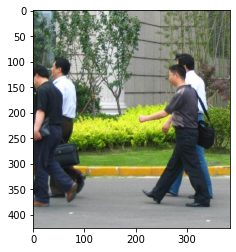

In [11]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
      
def get_instance_segmentation_model(num_classes):
    
######################model 2
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model



In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# for name, param in model.named_parameters():
#     print(name)
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# for name, param in model.named_parameters():
#     print(name)
in_features = model.roi_heads.box_predictor.cls_score.in_features


In [27]:
in_features


1024

In [13]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [14]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [16]:
# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:41  lr: 0.000090  loss: 1.2496 (1.2496)  loss_classifier: 1.0235 (1.0235)  loss_box_reg: 0.2048 (0.2048)  loss_objectness: 0.0136 (0.0136)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 0.6948  data: 0.1068  max mem: 3077
Epoch: [0]  [10/60]  eta: 0:00:18  lr: 0.000936  loss: 0.9558 (0.9080)  loss_classifier: 0.7199 (0.6345)  loss_box_reg: 0.2190 (0.2467)  loss_objectness: 0.0136 (0.0156)  loss_rpn_box_reg: 0.0077 (0.0112)  time: 0.3611  data: 0.0137  max mem: 3292
Epoch: [0]  [20/60]  eta: 0:00:13  lr: 0.001783  loss: 0.4970 (0.6979)  loss_classifier: 0.2711 (0.4406)  loss_box_reg: 0.2178 (0.2306)  loss_objectness: 0.0120 (0.0140)  loss_rpn_box_reg: 0.0113 (0.0127)  time: 0.3294  data: 0.0038  max mem: 3292
Epoch: [0]  [30/60]  eta: 0:00:10  lr: 0.002629  loss: 0.3450 (0.5529)  loss_classifier: 0.0993 (0.3200)  loss_box_reg: 0.1904 (0.2074)  loss_objectness: 0.0111 (0.0135)  loss_rpn_box_reg: 0.0106 (0.0120)  time: 0.3236  data: 0.0032  max mem: 3292
Epoch: [

In [17]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'model2-fasterrcnn.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(model.state_dict(), model_dir+model_name)

In [19]:
# pick one image from the test set
img, _ = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [20]:
#error because mask is not present in fast rcnn
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

KeyError: 'masks'

In [21]:
prediction

[{'boxes': tensor([[159.5332,  59.7457, 330.0887, 337.3184],
          [  0.4652,  59.5233,  51.2776, 177.3819],
          [175.4164,  61.4986, 264.2038, 307.0726],
          [  0.0000,  69.5910,  26.6459, 179.9672],
          [164.0253, 120.6508, 322.7964, 268.7607],
          [185.3734,  52.5665, 296.8031, 239.6102]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9936, 0.9658, 0.3754, 0.0785, 0.0682, 0.0554], device='cuda:0')}]

In [15]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

from models import *

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
# model = get_instance_segmentation_model(num_classes)

#will not match as default model size is 91
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# move model to the right device

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
# mask
# model.load_state_dict(torch.load('saved_models/model1.pt'))
#bundingbox
model.load_state_dict(torch.load('saved_models/model2-fasterrcnn.pt'))

<All keys matched successfully>

In [16]:
#other data
#convert image to tensor
import cv2
img = cv2.imread("22.png")
img = cv2.imread("2.jpg")
import numpy as np

img = np.array(img)
img = np.moveaxis(img,-1,0)
img = img/255
img = torch.from_numpy(img).float().to(device)
print(type(img))

<class 'torch.Tensor'>


In [17]:
# put the model in evaluation mode
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
with torch.no_grad():
    prediction = model([img.to(device)])

cuda


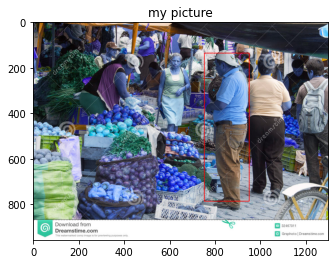

In [18]:
x1, y1, x2, y2 = prediction[0]['boxes'][0 ,:]
img = cv2.imread("2.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

from matplotlib import pyplot as plt

start_point = (x1, y1) 
  
# Ending coordinate, here (220, 220) 
# represents the bottom right corner of rectangle 
end_point = (x2, y2) 
  
# Blue color in BGR 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2
  
# Using cv2.rectangle() method 
# Draw a rectangle with blue line borders of thickness of 2 px 
img = cv2.rectangle(img, start_point, end_point, color, thickness) 
  

plt.imshow(img)
plt.title('my picture')
plt.show()

In [23]:
#other data
#convert image to tensor
import cv2
img = cv2.imread("22.png")
# img = cv2.imread("2.jpg")
import numpy as np

img = np.array(img)
img = np.moveaxis(img,-1,0)
img = img/255
img = torch.from_numpy(img).float().to(device)
print(type(img))

#key point detection 
modelk = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
modelk.to(device)
modelk.eval()
x = [torch.rand(3, 300, 400) ]
print((torch.rand(3, 300, 400).shape))
# print(img.unsqueeze(0).shape)
img = img.unsqueeze(0)
# print(img.shape)
predictions = modelk(img)

<class 'torch.Tensor'>
torch.Size([3, 300, 400])


In [24]:
predictions

[{'boxes': tensor([[429.4547,   0.0000, 653.8854, 527.2859],
          [312.7881,  33.2584, 465.3408, 562.1779],
          [419.3123,   1.1559, 564.0733, 431.5453],
          [  0.0000, 251.8944,  10.8132, 342.1043],
          [269.8071,  32.5961, 635.9444, 479.9993],
          [214.8281,  87.8171, 336.4816, 345.7060],
          [194.6760,  22.7993, 503.7590, 558.5699]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9997, 0.9943, 0.5364, 0.1579, 0.1143, 0.0682, 0.0656],
         device='cuda:0', grad_fn=<IndexBackward>),
  'keypoints': tensor([[[429.8075,  25.7988,   1.0000],
           [438.9824,   1.7670,   1.0000],
           [429.8075,   1.7670,   1.0000],
           [461.5666,   1.7670,   1.0000],
           [489.7969,  20.8511,   1.0000],
           [457.3321,  77.3965,   1.0000],
           [522.2617,  75.2761,   1.0000],
           [448.1572, 167.1624,   1.0000],
           [522.2617, 168.57